<h1>Copy raw data in your S3 bucket</h1>

In [1]:
import boto3
import sagemaker
import time


role = sagemaker.get_execution_role()
region = boto3.Session().region_name

print(region)
print(role)
 
# Replace initials placeholder.
#initials = '[initials]'
initials = 'ad82'
bucket_name = 'endtoendml-workshop-{0}'.format(initials)
prefix = '02'

print(bucket_name)

s3 = boto3.resource('s3')

copy_source = {
    'Bucket': 'gianpo-public',
    'Key': 'windturbine_raw_data.csv'
}

file_name = 'windturbine_raw_data.csv'
file_key = '{0}/data/{1}'.format(prefix, file_name)
s3.Bucket(bucket_name).copy(copy_source, file_key)
#s3.Bucket(bucket_name).download_file(file_key, file_name)

eu-west-1
arn:aws:iam::041631420165:role/service-role/AmazonSageMaker-ExecutionRole-20180507T143636
endtoendml-workshop-ad82


<h1>Create a Glue Crawler to infer schema for your data</h1>

NOTE: create Glue role in module 01

NOTE: SageMaker role has to have permissions for Glue Full Access

In [2]:
glue_client = boto3.client('glue')
response = glue_client.create_database(DatabaseInput={'Name': 'endtoendml-db'})
response = glue_client.get_database(Name='endtoendml-db')
response
assert response['Database']['Name'] == 'endtoendml-db'


In [3]:
response = glue_client.create_crawler(
    Name='endtoendml-crawler',
    Role='AWSGlueServiceRole', ## VEDI NOTA SU!!
    DatabaseName='endtoendml-db',
    Targets={'S3Targets': [{'Path': '{0}/{1}/data/'.format(bucket_name, prefix)}]}
)

In [4]:
glue_client.start_crawler(Name='endtoendml-crawler')

{'ResponseMetadata': {'RequestId': 'bc8568ff-c81c-11e9-9679-331c613291e2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Aug 2019 16:15:47 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'bc8568ff-c81c-11e9-9679-331c613291e2'},
  'RetryAttempts': 0}}

In [5]:
glue_client.get_crawler_metrics(CrawlerNameList=['endtoendml-crawler'])

{'CrawlerMetricsList': [{'CrawlerName': 'endtoendml-crawler',
   'TimeLeftSeconds': 0.0,
   'StillEstimating': True,
   'LastRuntimeSeconds': 0.0,
   'MedianRuntimeSeconds': 0.0,
   'TablesCreated': 0,
   'TablesUpdated': 0,
   'TablesDeleted': 0}],
 'ResponseMetadata': {'RequestId': 'c4d8e989-c81c-11e9-ae01-4b6d9fe8ec5c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Aug 2019 16:15:49 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '212',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c4d8e989-c81c-11e9-ae01-4b6d9fe8ec5c'},
  'RetryAttempts': 0}}

In [6]:
while glue_client.get_crawler_metrics(CrawlerNameList=['endtoendml-crawler'])['CrawlerMetricsList'][0]['TablesCreated'] == 0:
    time.sleep(5)
    
assert glue_client.get_crawler_metrics(CrawlerNameList=['endtoendml-crawler'])['CrawlerMetricsList'][0]['TablesCreated'] == 1


In [7]:
!pip install pyathena

You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
import pyathena
from pyathena import connect
import pandas as pd


conn = connect(s3_staging_dir='s3://{0}/{1}/staging/'.format(bucket_name, prefix), 
               region_name='eu-west-1')

df = pd.read_sql('SELECT * FROM "endtoendml-db".data limit 8;', conn)
df


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11
0,TID003,HAWT,80,61,NaN,34,33,26,1,77,E,no
1,TID010,HAWT,85,78,36.0,28,35,43,15,62,NE,yes
2,TID007,HAWT,47,31,31.0,23,46,62,15,32,N,no
3,TID008,VAWT,73,70,38.0,8,17,66,6,80,SW,yes
4,TID003,HAWT,16,23,46.0,9,76,53,14,29,W,no
5,TID001,HAWT,78,71,30.0,11,66,79,1,81,SW,no
6,TID009,HAWT,80,25,37.0,31,40,75,4,56,NW,no
7,TID002,VAWT,59,29,37.0,10,25,83,13,55,SE,no


As you can see column names are not defined, so let's modify the AWS Glue table

In [9]:
table = glue_client.get_table(DatabaseName='endtoendml-db', Name='data')
table

{'Table': {'Name': 'data',
  'DatabaseName': 'endtoendml-db',
  'Owner': 'owner',
  'CreateTime': datetime.datetime(2019, 8, 26, 16, 17, 2, tzinfo=tzlocal()),
  'UpdateTime': datetime.datetime(2019, 8, 26, 16, 17, 2, tzinfo=tzlocal()),
  'LastAccessTime': datetime.datetime(2019, 8, 26, 16, 17, 2, tzinfo=tzlocal()),
  'Retention': 0,
  'StorageDescriptor': {'Columns': [{'Name': 'col0', 'Type': 'string'},
    {'Name': 'col1', 'Type': 'string'},
    {'Name': 'col2', 'Type': 'bigint'},
    {'Name': 'col3', 'Type': 'bigint'},
    {'Name': 'col4', 'Type': 'double'},
    {'Name': 'col5', 'Type': 'bigint'},
    {'Name': 'col6', 'Type': 'bigint'},
    {'Name': 'col7', 'Type': 'bigint'},
    {'Name': 'col8', 'Type': 'bigint'},
    {'Name': 'col9', 'Type': 'bigint'},
    {'Name': 'col10', 'Type': 'string'},
    {'Name': 'col11', 'Type': 'string'}],
   'Location': 's3://endtoendml-workshop-ad82/02/data/',
   'InputFormat': 'org.apache.hadoop.mapred.TextInputFormat',
   'OutputFormat': 'org.apache.

In [10]:
table['Table']['StorageDescriptor']['Columns'] = [{'Name': 'turbine_id', 'Type': 'string'},
                                                  {'Name': 'turbine_type', 'Type': 'string'},
                                                  {'Name': 'wind_speed', 'Type': 'bigint'},
                                                  {'Name': 'RPM_blade', 'Type': 'bigint'},
                                                  {'Name': 'col4float', 'Type': 'double'},
                                                  {'Name': 'oil_level', 'Type': 'bigint'},
                                                  {'Name': 'temperature', 'Type': 'bigint'},
                                                  {'Name': 'humidity', 'Type': 'bigint'},
                                                  {'Name': 'vibrations_frequency', 'Type': 'bigint'},
                                                  {'Name': 'pressure', 'Type': 'bigint'},
                                                  {'Name': 'wind_direction', 'Type': 'string'},
                                                  {'Name': 'breakdown', 'Type': 'string'}]


In [11]:
updated_table = table['Table']
updated_table.pop('DatabaseName', None)
updated_table.pop('CreateTime', None)
updated_table.pop('UpdateTime', None)
updated_table.pop('CreatedBy', None)
updated_table.pop('IsRegisteredWithLakeFormation', None)

glue_client.update_table(
    DatabaseName='endtoendml-db',
    TableInput=updated_table
)

{'ResponseMetadata': {'RequestId': '0fd84847-c81d-11e9-ae01-4b6d9fe8ec5c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 26 Aug 2019 16:17:55 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '0fd84847-c81d-11e9-ae01-4b6d9fe8ec5c'},
  'RetryAttempts': 0}}

Let's try to run a first SQL query to see how are data look like

In [12]:
df = pd.read_sql('SELECT * FROM "endtoendml-db".data limit 8;', conn)
df

,turbine_id,turbine_type,wind_speed,rpm_blade,col4float,oil_level,temperature,humidity,vibrations_frequency,pressure,wind_direction,breakdown
0,TID003,HAWT,80,61,NaN,34,33,26,1,77,E,no
1,TID010,HAWT,85,78,36.0,28,35,43,15,62,NE,yes
2,TID007,HAWT,47,31,31.0,23,46,62,15,32,N,no
3,TID008,VAWT,73,70,38.0,8,17,66,6,80,SW,yes
4,TID003,HAWT,16,23,46.0,9,76,53,14,29,W,no
5,TID001,HAWT,78,71,30.0,11,66,79,1,81,SW,no
6,TID009,HAWT,80,25,37.0,31,40,75,4,56,NW,no
7,TID002,VAWT,59,29,37.0,10,25,83,13,55,SE,no


Another SQL query to count how many records we have

In [13]:
pd.read_sql('SELECT COUNT(*) FROM "endtoendml-db".data;', conn)

,_col0
0,1000000


Let's try to see what are possible values for the field "alarm" and how frequently they occur over the entire dataset

In [15]:
pd.read_sql('SELECT breakdown, (COUNT(breakdown) * 100.0 / (SELECT COUNT(*) FROM "endtoendml-db".data)) \
            AS percent FROM "endtoendml-db".data GROUP BY breakdown;', conn)


,breakdown,percent
0,no,86.3421
1,yes,13.6579


Now we want to see if there is a correlation between temperature and humidity. To do so we run a SQL query to select only these two columns and populate a Pandas dataframe that we will use for our analysis

In [16]:
temp_hum_df = pd.read_sql('SELECT temperature, humidity FROM "endtoendml-db".data', conn)
temp_hum_df.head()

,temperature,humidity
0,33,26
1,35,43
2,46,62
3,17,66
4,76,53


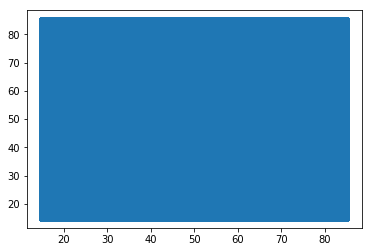

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(temp_hum_df.temperature, temp_hum_df.humidity)

(array([ 98090.,  98843.,  98548.,  98634.,  98428.,  98883.,  98715.,
         98691.,  98457., 112711.]),
 array([15., 22., 29., 36., 43., 50., 57., 64., 71., 78., 85.]),
 <a list of 10 Patch objects>)

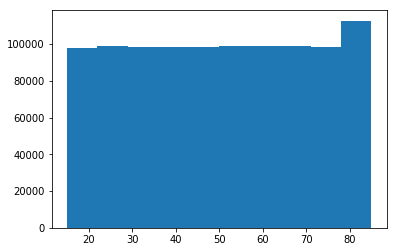

In [18]:
plt.hist(temp_hum_df.humidity, bins=10)

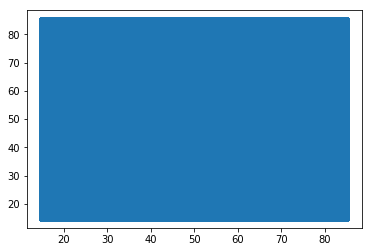

In [19]:
wind_rpm_df = pd.read_sql('SELECT wind_speed, rpm_blade FROM "endtoendml-db".data', conn)
plt.scatter(wind_rpm_df.wind_speed, wind_rpm_df.rpm_blade)

Note: you can go to Amazon Athena console and check for query duration under History tab: usually queries are executed in a few seconds, then it takes a while for pandas to load results into a dataframe

In [ ]:
wind_rpm_df.describe()

Now we select our entire dataset and populate a dataframe.  

In [20]:
df = pd.read_sql('SELECT * FROM "endtoendml-db".data;', conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
turbine_id              1000000 non-null object
turbine_type            1000000 non-null object
wind_speed              1000000 non-null int64
rpm_blade               1000000 non-null int64
col4float               961703 non-null float64
oil_level               1000000 non-null int64
temperature             1000000 non-null int64
humidity                1000000 non-null int64
vibrations_frequency    1000000 non-null int64
pressure                1000000 non-null int64
wind_direction          1000000 non-null object
breakdown               1000000 non-null object
dtypes: float64(1), int64(7), object(4)
memory usage: 91.6+ MB


You can notice that col4float has some missing values

In [21]:
df.describe(include=['object', 'int64', 'float64'])

,turbine_id,turbine_type,wind_speed,rpm_blade,col4float,oil_level,temperature,humidity,vibrations_frequency,pressure,wind_direction,breakdown
count,1000000,1000000,1000000.000000,1000000.000000,961703.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000
unique,10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2
top,TID004,HAWT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,no
freq,100268,699712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125438,863421
mean,NaN,NaN,49.990414,50.010095,37.435021,19.998577,50.023570,50.014965,7.994064,49.985960,NaN,NaN
std,NaN,NaN,20.486019,20.498963,7.640262,8.944855,20.496239,20.483369,4.319314,20.501076,NaN,NaN
min,NaN,NaN,15.000000,15.000000,25.000000,5.000000,15.000000,15.000000,1.000000,15.000000,NaN,NaN
25%,NaN,NaN,32.000000,32.000000,31.000000,12.000000,32.000000,32.000000,4.000000,32.000000,NaN,NaN
50%,NaN,NaN,50.000000,50.000000,37.000000,20.000000,50.000000,50.000000,8.000000,50.000000,NaN,NaN
75%,NaN,NaN,68.000000,68.000000,44.000000,28.000000,68.000000,68.000000,12.000000,68.000000,NaN,NaN


In [23]:
df['turbine_type'].unique()

array(['HAWT', 'VAWT', ''], dtype=object)

In [27]:
ETLJob = glue_client.create_job(Name='endtoendml-job', Role='AWSGlueServiceRole',
                          Command={'Name': 'glueetl',
                                   'ScriptLocation': 's3://antoduma-res/my_etl.py'})

In [28]:
JobRun = glue_client.start_job_run(JobName=ETLJob['Name'], 
                                  Arguments = {'--bucket': bucket_name})
status = glue_client.get_job_run(JobName=ETLJob['Name'], RunId=JobRun['JobRunId'])
while status['JobRun']['JobRunState'] != 'SUCCEEDED' and status['JobRun']['JobRunState'] != 'FAILED':
    time.sleep(5)
    status = glue_client.get_job_run(JobName=ETLJob['Name'], RunId=JobRun['JobRunId'])

assert status['JobRun']['JobRunState'] == 'SUCCEEDED'
    
#This will take around 6 minutes